<a href="https://colab.research.google.com/github/sgowda6/Chicago-Crime-Pattern/blob/main/IDS561_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.pair.com/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
#Create spark session

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

#import libraries
import pandas as pd
import re
from pyspark import SparkContext
import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType

In [ ]:
#read CSV into a DF
df = spark.read.format('csv').options(header='true').load('Crimes_-_2013_to_Present.csv')

In [ ]:
#display df

df.show()
df.count()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------+--------+---------+--------+
|      ID|Case_Number|                Date|               Block|IUCR|        Primary_Type|         Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X Coordinate|Y Coordinate|Year|      Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------+--------+---------+--------+
|12187137|   JD392006|01/01/2013 12:00:...|093XX S MANISTEE AVE|1585|         SEX OFFENSE|               OTHER|           RESIDENCE| FALSE|    TRUE| 423|       4|   7|            48|      17|     

1048575

In [ ]:
#drop all NA values

df = df.dropna()

In [ ]:
#check count of data we're dealing with

df.count()

1036661

In [ ]:
#df will be read again and again, so cache it

df = df.cache()

In [ ]:
#check schema

df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case_Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community_Area: string (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
#drop columns that we do not require for our analysis

df = df.drop("X Coordinate","Y Coordinate","Latitude","Longitude","Location","Updated On")

In our crimes dataframe, the column 'Community Area' is an indicator of which community area of Chicago a crime occurs in. We have manually created a data frame by collecting the area and matching it with the Community Area code from the Population and Poverty Data by Chicago Community Area (December 2017).  

http://www.actforchildren.org/wp-content/uploads/2018/01/Census-Data-by-Chicago-Community-Area-2017.pdf

In [ ]:
#manually insert community area codes and area names into Community_Area list

from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType
Community_Area = [ Row(1, "Rogers Park","Far North side"),Row(2, "West Ridge","Far North side"),Row(3, "Uptown","Far North side"),Row(4, "Lincoln Square","Far North side"),
               Row(5, "North Center","North side"),Row(6, "Lake View","North side"),Row(7, "Lincoln Park","North side"),Row(8, "Near North Side","Central"),
               Row(9, "Edison Park","Far North side"),Row(10, "Norwood Park","Far North side"),Row(11, "Jefferson Park","Far North side"),Row(12, "Forest Glen","Far North side"),
               Row(13, "North Park","Far North side"),Row(14, "Albany Park","Far North side"),Row(15, "Portage Park","Northwest side"),Row(16, "Irving Park","Northwest side"),
               Row(17, "Dunning","Northwest side"),Row(18, "Montclare","Northwest side"),Row(19, "Belmont Cragin","Northwest side"),Row(20, "Hermosa","Northwest side"),
               Row(21, "Avondale","North side"),Row(22, "Logan Square","North side"),Row(23, "Humboldt Park", "West side"),Row(24, "West Town","West side"),
               Row(25, "Austin","West side"),Row(26, "West Garfield Park","West side"),Row(27, "East Garfield Park","West side"),Row(28, "Near West Side","West side"),
               Row(29, "North Lawndale","West side"),Row(30, "South Lawndale","West side"),Row(31, "Lower West Side","West side"),Row(32, "Loop","Central"),
               Row(33, "Near South Side","Central"),Row(34, "Armour Square","South side"),Row(35, "Douglas","South side"),Row(36, "Oakland","South side"),
               Row(37, "Fuller Park","South side"),Row(38, "Grand Boulevard","South side"),Row(39, "Kenwood","South side"),Row(40, "Washington Park","South side"),
               Row(41, "Hyde Park","South side"),Row(42, "Woodlawn","South side"),Row(43, "South Shore","South side"),Row(44, "Chatham","Far Southeast side"),
               Row(45, "Avalon Park","Far Southeast side"),Row(46, "South Chicago","Far Southeast side"),Row(47, "Burnside","Far Southeast side"),Row(48, "Calumet Heights","Far Southeast side"),
               Row(49, "Roseland","Far Southeast side"),Row(50, "Pullman","Far Southeast side"),Row(51, "South Deering","Far Southeast side"),Row(52, "East Side","Far Southeast side"),
               Row(53, "West Pullman","Far Southeast side"),Row(54, "Riverdale","Far Southeast side"),Row(55, "Hegewisch","Far Southeast side"),Row(56, "Garfield Ridge","Southwest side"),
               Row(57, "Archer Heights","Southwest side"),Row(58, "Brighton Park","Southwest side"),Row(59, "McKinley Park","Southwest side"),Row(60, "Bridgeport","South side"),
               Row(61, "New City","Southwest side"),Row(62, "West Elsdon","Southwest side"),Row(63, "Gage Park","Southwest side"),Row(64, "Clearing","Southwest side"),
               Row(65, "West Lawn","Southwest side"),Row(66, "Chicago Lawn","Southwest side"),Row(67, "West Englewood","Southwest side"),Row(68, "Englewood","Southwest side"),
               Row(69, "Greater Grand Crossing","South side"),Row(70, "Ashburn","Far Southwest side"),Row(71, "Auburn Gresham","Far Southwest side"),Row(72, "Beverly","Far Southwest side"),
               Row(73, "Washington Heights","Far Southwest side"),Row(74, "Mount Greenwood","Far Southwest side"),Row(75, "Morgan Park","Far Southwest side"),Row(76, "O'Hare","Far North side"),
               Row(77, "Edgewater","Far North side")]


In [ ]:
#Define schema for the above list and store it into a dataframe

community_schema = StructType([ StructField("Community_Area", IntegerType(), False),
                                StructField("Area_name", StringType(), True),
                          StructField("Area_side", StringType(), True)])
#create spark dataframe
communityDf = spark.createDataFrame(Community_Area, community_schema)

#view
communityDf.show(truncate=False)

+--------------+---------------+--------------+
|Community_Area|Area_name      |Area_side     |
+--------------+---------------+--------------+
|1             |Rogers Park    |Far North side|
|2             |West Ridge     |Far North side|
|3             |Uptown         |Far North side|
|4             |Lincoln Square |Far North side|
|5             |North Center   |North side    |
|6             |Lake View      |North side    |
|7             |Lincoln Park   |North side    |
|8             |Near North Side|Central       |
|9             |Edison Park    |Far North side|
|10            |Norwood Park   |Far North side|
|11            |Jefferson Park |Far North side|
|12            |Forest Glen    |Far North side|
|13            |North Park     |Far North side|
|14            |Albany Park    |Far North side|
|15            |Portage Park   |Northwest side|
|16            |Irving Park    |Northwest side|
|17            |Dunning        |Northwest side|
|18            |Montclare      |Northwes

In [ ]:
#Join Community_Area dataframe with original dataframe df
df = df.join(communityDf,"Community_Area",'inner')

In [ ]:
#Check
df

DataFrame[Community_Area: string, ID: string, Case_Number: string, Date: string, Block: string, IUCR: string, Primary_Type: string, Description: string, Location_Description: string, Arrest: string, Domestic: string, Beat: string, District: string, Ward: string, FBI_Code: string, Year: string, Area_name: string, Area_side: string]

District variables in the crime data frame represent the number of the police district where the incident took place.
Adding the name of the police district would provide additional context required for review. There are 22 police districts, each of which has a police name and was accessed from the Data Portal of the City of Chicago.
https://www.chicago.gov/city/en/depts/cpd/dataset/police_stations.html

In [ ]:
#read the police station data into a spark dataframe

police_station = spark.read \
                 .format("csv") \
                 .option("mode","FAILFAST") \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .load("Police_Stations.csv")

In [ ]:
#Join the police station df with df2
df = df.join(police_station,"District",'inner')

In [ ]:
#check
df

DataFrame[District: string, Community_Area: string, ID: string, Case_Number: string, Date: string, Block: string, IUCR: string, Primary_Type: string, Description: string, Location_Description: string, Arrest: string, Domestic: string, Beat: string, Ward: string, FBI_Code: string, Year: string, Area_name: string, Area_side: string, District_Name: string, Address: string, CITY: string, STATE: string, ZIP: int, WEBSITE: string, PHONE: string, FAX: string, TTY: string, X COORDINATE: double, Y COORDINATE: double, LATITUDE: double, LONGITUDE: double, LOCATION: string]

In [ ]:
#drop unnecessary columns from df2
df = df.drop("CITY","STATE","ZIP","WEBSITE","PHONE","FAX","TTY","X COORDINATE","Y COORDINATE","LATITUDE","LONGITUDE","LOCATION")

In [ ]:
#check
df

DataFrame[District: string, Community_Area: string, ID: string, Case_Number: string, Date: string, Block: string, IUCR: string, Primary_Type: string, Description: string, Location_Description: string, Arrest: string, Domestic: string, Beat: string, Ward: string, FBI_Code: string, Year: string, Area_name: string, Area_side: string, District_Name: string, Address: string]

**EXPLORATORY DATA ANALYSIS**

**1. Visualize top ten crimes in Chicago**

In [ ]:
#Types of Crime in Chicago
crime_types = df.groupBy('Primary_Type').count()

In [ ]:
crime_type_counts = crime_types.orderBy('count', ascending=False)


In [ ]:
#view top most occured crime types by number

crime_type_counts.show(truncate=False)


+--------------------------------+------+
|Primary_Type                    |count |
+--------------------------------+------+
|THEFT                           |234200|
|BATTERY                         |190488|
|CRIMINAL DAMAGE                 |110440|
|NARCOTICS                       |95531 |
|ASSAULT                         |66036 |
|OTHER OFFENSE                   |65101 |
|BURGLARY                        |55687 |
|DECEPTIVE PRACTICE              |54822 |
|MOTOR VEHICLE THEFT             |40513 |
|ROBBERY                         |39690 |
|CRIMINAL TRESPASS               |26796 |
|WEAPONS VIOLATION               |12285 |
|PUBLIC PEACE VIOLATION          |9667  |
|OFFENSE INVOLVING CHILDREN      |8408  |
|PROSTITUTION                    |5249  |
|CRIM SEXUAL ASSAULT             |4854  |
|INTERFERENCE WITH PUBLIC OFFICER|4672  |
|SEX OFFENSE                     |3534  |
|HOMICIDE                        |1919  |
|ARSON                           |1605  |
+--------------------------------+

In [ ]:
#convert to pandas 

crime_type_counts.toPandas()

In [ ]:
#convert back to rdd

counts = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())

In [ ]:
#store top ten crime records in x

x=counts.head(10)
x

,Primary_Type,count
0,THEFT,234200
1,BATTERY,190488
2,CRIMINAL DAMAGE,110440
3,NARCOTICS,95531
4,ASSAULT,66036
5,OTHER OFFENSE,65101
6,BURGLARY,55687
7,DECEPTIVE PRACTICE,54822
8,MOTOR VEHICLE THEFT,40513
9,ROBBERY,39690


In [ ]:
#import libraries for plotting

import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pyspark.sql.functions import *

[Text(0, 0.5, 'Type of crime'), Text(0.5, 0, 'Number of crimes')]

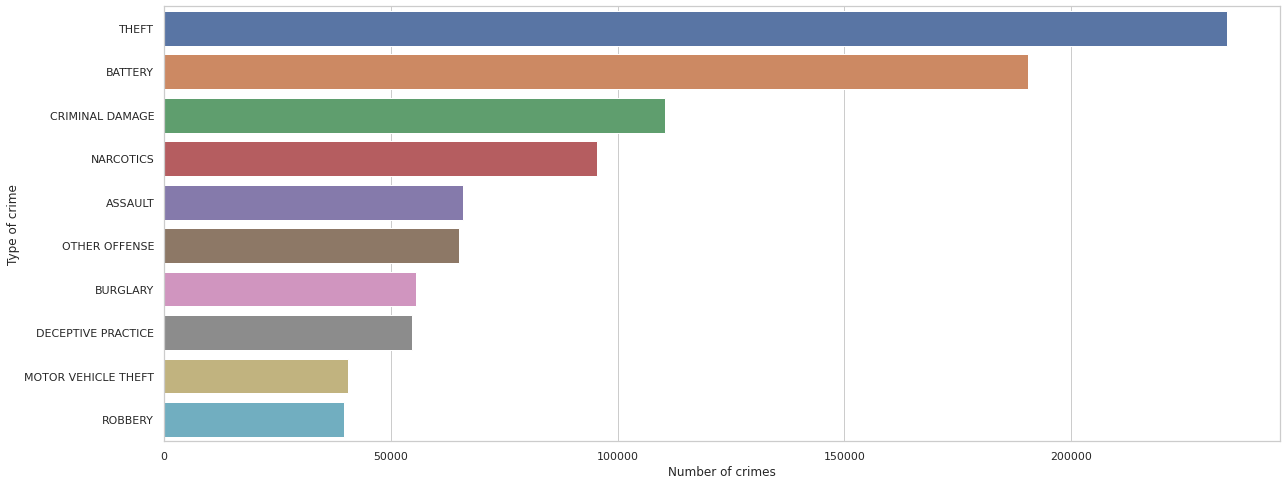

In [ ]:
# Visualizing top ten crime types by count 

plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")

type_graph = sns.barplot(x='count', y='Primary_Type', data=x)
type_graph.set(ylabel="Type of crime", xlabel="Number of crimes")

**2. Visualize arrests over the years**

In [ ]:
# Arrests, year, count through the years
arrest_type = df.groupBy(['Arrest', 'Year'])\
                     .count()\
                     .orderBy(['Year', 'count'], ascending=[True, False])
print()
arrest_type.show(3, truncate=False)


+------+----+------+
|Arrest|Year|count |
+------+----+------+
|FALSE |2013|219872|
|TRUE  |2013|86431 |
|FALSE |2014|194301|
+------+----+------+
only showing top 3 rows



In [ ]:
# A pandas data frame of above
arrest_type_p = pd.DataFrame(arrest_type.rdd.map(lambda l: l.asDict()).collect())

In [ ]:
# Plot
t = arrest_type_p['count'] - 20 
s = arrest_type_p['Year']

#store arrested records and non-arrested records seperately
arrested = arrest_type_p[type_arrest_pddf['Arrest'] == 'TRUE']
not_arrested = arrest_type_p[type_arrest_pddf['Arrest'] == 'FALSE']

fig, ax = plt.subplots()
ax.plot(arrested['Year'], arrested['count'], label='Arrested')
ax.plot(not_arrested['Year'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Years', ylabel='Total records',
       title='Arrests over the years')
ax.grid(b=True, which='both', axis='y')
ax.legend()

**3. Visualize number of crimes in each Location type (top 10)**

In [ ]:
df.select('Location_Description').distinct().count()

156

In [ ]:
#grouping locations and displaying count (ASC order)

Loc_desc = df.groupBy(['Location_Description']).count().orderBy('count', ascending=False)

In [ ]:
#conver to pandas

LD = pd.DataFrame(Loc_desc.rdd.map(lambda l: l.asDict()).collect())

In [ ]:
#ake top 10 records

LD = LD.head(10)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Locations (Chicago)'),
 Text(0.5, 1.0, 'Number of crimes location wise')]

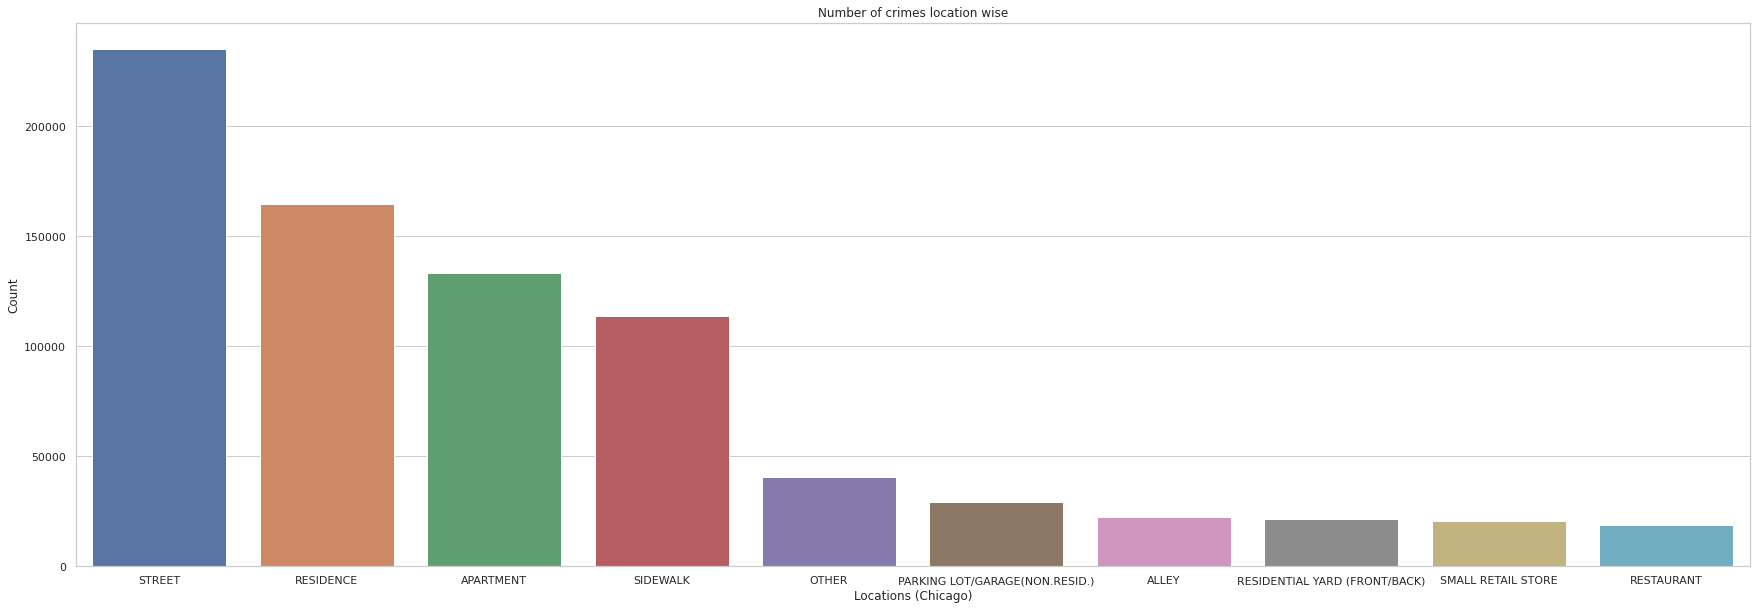

In [ ]:
# Plot

plt.rcParams["figure.figsize"] = [30, 10]

sns.set(style="whitegrid")

type_graph = sns.barplot(x='Location_Description', y='count', data=LD)
type_graph.set(ylabel="Count", xlabel="Locations (Chicago)",title='Number of crimes location wise')

**4.Top 10 police stations (with District names) with domestic violence arrest rate**

In [ ]:
#total count of domestic crimes
totCrimeDF = df.where(col("Domestic")==True).count()


print("Summary of the arrests which occurred for domestic violence for each Police Station")
df.where((col("Arrest")==True) & ((col("Domestic")==True)))\
           .select("District_Name","arrest","domestic")\
           .groupBy("District_Name")\
           .agg(count("District_Name").alias("Domestic Violence Arrest Rate"),\
                  (count("District_Name")/totCrimeDF*100).alias("Rate"))\
           .orderBy(col("Domestic Violence Arrest Rate").desc())\
           .select("District_Name","Domestic Violence Arrest Rate",round("Rate",2).alias("Ratio=Domestic Violence Cases/Reported Crimes")).show(10)

Summary of the arrests which occurred for domestic violence for each Police Station
+--------------+-----------------------------+---------------------------------------------+
| District_Name|Domestic Violence Arrest Rate|Ratio=Domestic Violence Cases/Reported Crimes|
+--------------+-----------------------------+---------------------------------------------+
|       Gresham|                         2572|                                         1.61|
| South Chicago|                         2509|                                         1.57|
| Grand Central|                         2424|                                         1.52|
|     Englewood|                         2363|                                         1.48|
|  Chicago Lawn|                         2171|                                         1.36|
|Grand Crossing|                         2109|                                         1.32|
|      Harrison|                         2079|                                 

**Lets handle the Date column which is in String type**

In [ ]:
#Convert to timestamp type
df = df.withColumn('date_time', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('date_short', trunc('date_time', 'YYYY'))

In [ ]:
#check
df

DataFrame[District: string, Community_Area: string, ID: string, Case_Number: string, Date: string, Block: string, IUCR: string, Primary_Type: string, Description: string, Location_Description: string, Arrest: string, Domestic: string, Beat: string, Ward: string, FBI_Code: string, Year: string, Area_name: string, Area_side: string, District_Name: string, Address: string, date_time: timestamp, date_short: date]

In [ ]:
# Take the 'hour' part of time into a new column called 'hour'
df_hour = df.withColumn('hour', hour(df['date_time']))

In [ ]:
df_hour

DataFrame[District: string, Community_Area: string, ID: string, Case_Number: string, Date: string, Block: string, IUCR: string, Primary_Type: string, Description: string, Location_Description: string, Arrest: string, Domestic: string, Beat: string, Ward: string, FBI_Code: string, Year: string, Area_name: string, Area_side: string, District_Name: string, Address: string, date_time: timestamp, date_short: date, hour: int]

In [ ]:
#create a df with week, year and month columns
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [ ]:
#display all time columns 
df_dates.select(['date', 'date_short', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |date_short|hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|01/01/2013 12:00:00 AM|2013-01-01|0   |3       |2013|1         |1        |4383       |
|01/01/2013 12:30:00 AM|2013-01-01|0   |3       |2013|1         |1        |4383       |
|01/01/2013 01:30:00 AM|2013-01-01|1   |3       |2013|1         |1        |4383       |
|01/01/2013 04:37:00 AM|2013-01-01|4   |3       |2013|1         |1        |4383       |
|01/01/2013 06:00:00 AM|2013-01-01|6   |3       |2013|1         |1        |4383       |
|01/01/2013 07:00:00 AM|2013-01-01|7   |3       |2013|1         |1        |4383       |
|01/01/2013 09:00:00 AM|2013-01-01|9   |3       |2013|1         |1        |4383       |
|01/01/2013 09:00:00 AM|2013-01-01|9   |3       |2013|1         |1        |4383       |
|01/01/2013 05:20:00 PM|2013-01-

**5. Lets visualize which is the peak hour of the day for crimes in Chicago**

In [ ]:
# Derive a data frame with crime counts per hour of the day:
count_by_hour = df_hour.groupBy(['Primary_Type', 'hour']).count().cache()
total_countbyhour = count_by_hour.groupBy('hour').sum('count')

In [ ]:
count_by_hour_p = pd.DataFrame(total_countbyhour.select(total_countbyhour['hour'], total_countbyhour['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [ ]:
#sort by hours in ascending, to represent hours through the day
count_by_hour_p = count_by_hour_p.sort_values(by='hour')

In [ ]:
count_by_hour_p

,hour,count
22,0,49618
2,1,30962
21,2,26781
6,3,22059
13,4,16610
8,5,14394
4,6,17487
16,7,24378
14,8,35606
11,9,47825


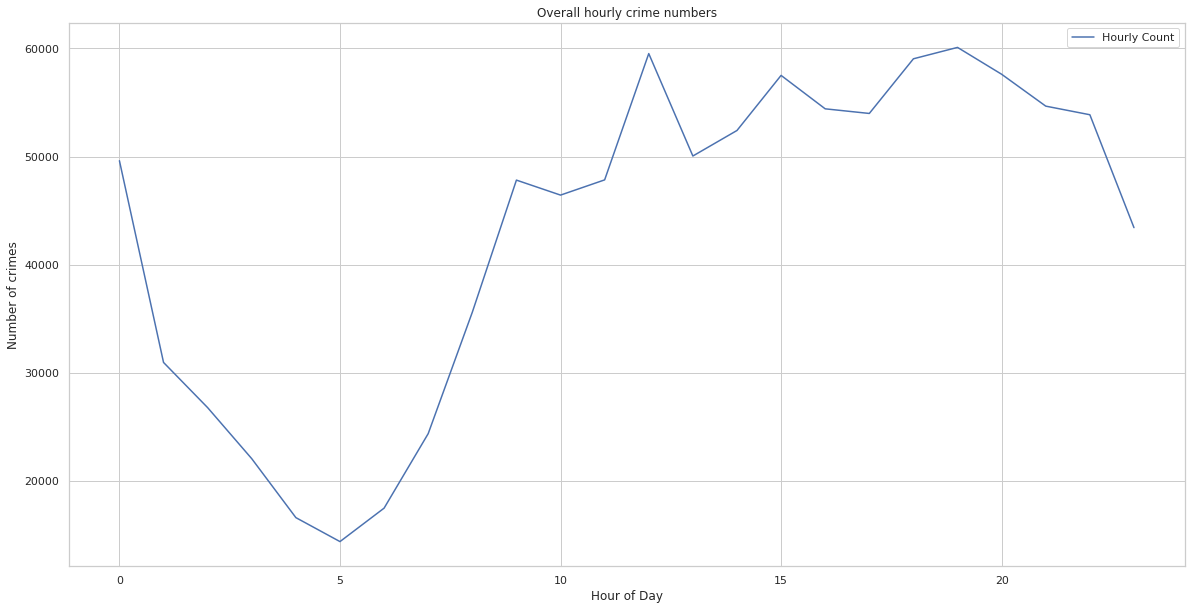

In [ ]:
#plot 

plt.rcParams["figure.figsize"] = [20, 10]
fig, ax = plt.subplots()
ax.plot(count_by_hour_p['hour'], count_by_hour_p['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Number of crimes',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

**6. Let us visualize crimes by days of week, months of year and year**

In [ ]:
crimes_by_weekday = df_dates.groupBy('week_day').count()

In [ ]:
#convert to pandas dataframe

crimes_by_weekday_p = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

[Text(0, 0.5, 'Number of crimes'),
 Text(0.5, 0, 'Days of the week'),
 Text(0.5, 1.0, 'Number of crimes by days of the week')]

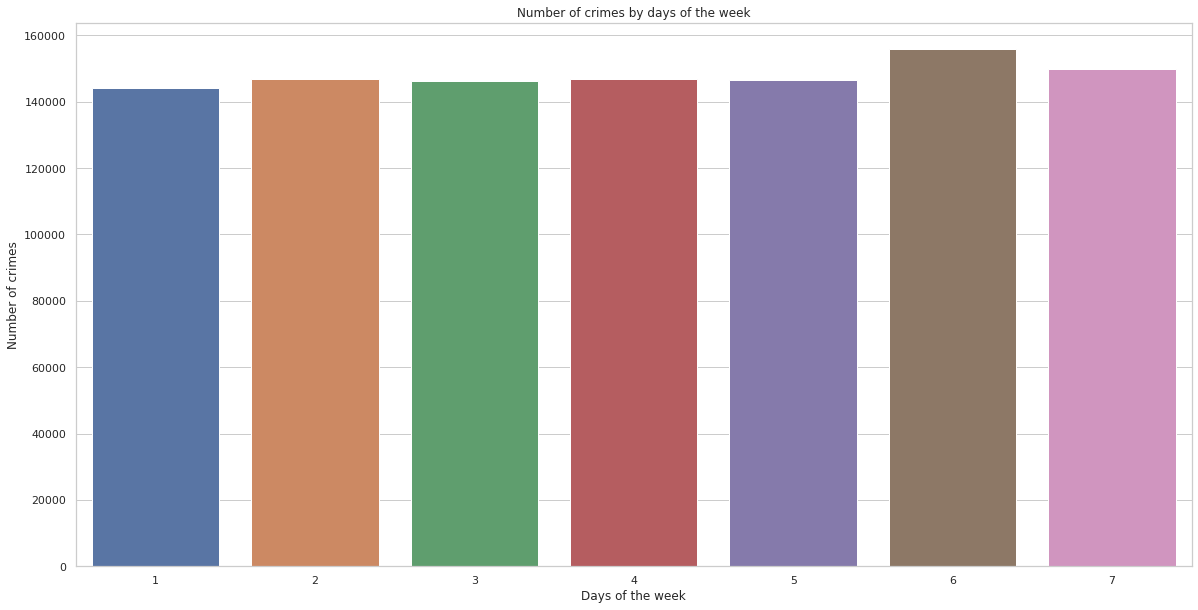

In [ ]:
plt.rcParams["figure.figsize"] = [20, 10]

sns.set(style="whitegrid")

type_graph = sns.barplot(x='week_day', y='count', data=crimes_by_weekday_p)
type_graph.set(ylabel="Number of crimes", xlabel="Days of the week",title="Number of crimes by days of the week")

In [ ]:
crime_by_month = df_dates.groupBy('year_month').count()

#convert to pandas
crime_by_month_p = pd.DataFrame(crime_by_month.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

[Text(0, 0.5, 'Number of crimes'),
 Text(0.5, 0, 'Months of the year'),
 Text(0.5, 1.0, 'Number of crimes by months of year')]

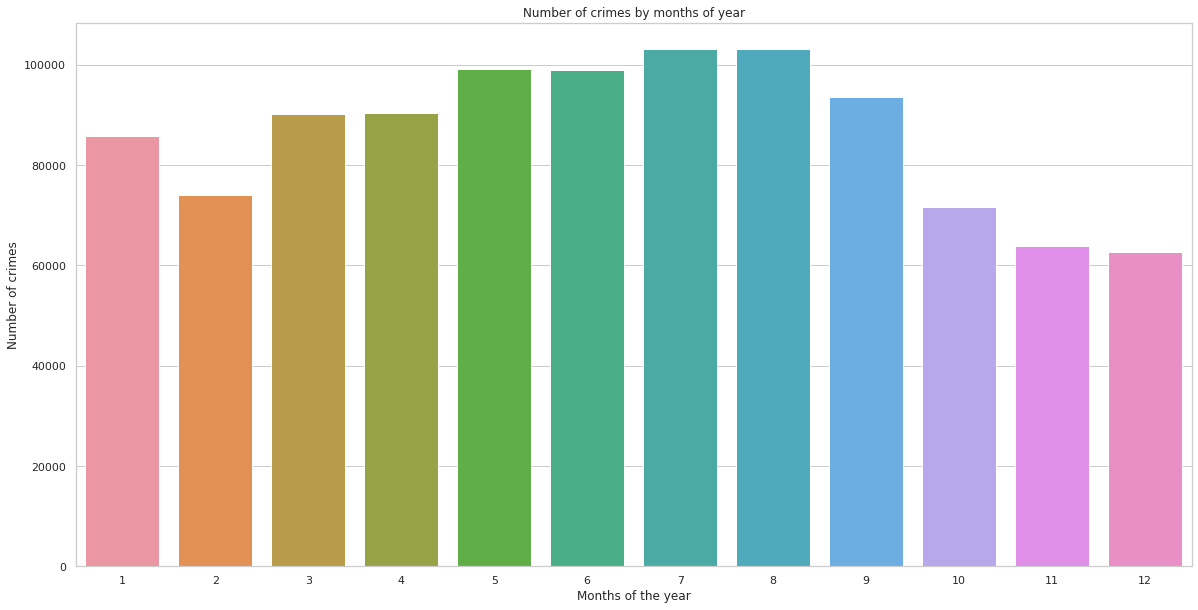

In [ ]:
plt.rcParams["figure.figsize"] = [20, 10]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

type_graph = sns.barplot(x='year_month', y='count', data=year_month_crime_counts_pddf)
type_graph.set(ylabel="Number of crimes", xlabel="Months of the year",title="Number of crimes by months of year")

**PREDICTION MODEL**
Selected Predictors - 
'location_description'
'arrest'
'domestic'
'beat'
'district'
'ward'
'community_area'
'fbi_code'
'hour'
'week_day'
'year_month'
'month_day'
'date_number'



In [ ]:
#store our selected features 
features = [
 'Location_Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community_Area',
 'FBI_Code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [ ]:
#Schema 
model_features = df_dates.select(features)
model_features.printSchema()

root
 |-- Location_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community_Area: string (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- week_day: integer (nullable = true)
 |-- year_month: integer (nullable = true)
 |-- month_day: integer (nullable = true)
 |-- date_number: integer (nullable = true)



Indexing the string features from our selected list, to build a smooth model

In [ ]:
#import required libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler


In [ ]:
df_dates_features = df_dates.na.drop(subset=features)

In [ ]:
dic = []

for feature in features:
    print('Analysing %s' % feature)
    levels = model_features.select(feature).distinct()
    dic.append({'feature': feature, 'level_count': levels.count()})

Analysing Location_Description
Analysing Arrest
Analysing Domestic
Analysing Beat
Analysing District
Analysing Ward
Analysing Community_Area
Analysing FBI_Code
Analysing hour
Analysing week_day
Analysing year_month
Analysing month_day
Analysing date_number


In [ ]:


for feature in dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

Fitting feature "Location_Description"
Transforming "Location_Description"
Fitting feature "Arrest"
Transforming "Arrest"
Fitting feature "Domestic"
Transforming "Domestic"
Fitting feature "Beat"
Transforming "Beat"
Fitting feature "District"
Transforming "District"
Fitting feature "Ward"
Transforming "Ward"
Fitting feature "Community_Area"
Transforming "Community_Area"
Fitting feature "FBI_Code"
Transforming "FBI_Code"
Fitting feature "hour"
Transforming "hour"
Fitting feature "week_day"
Transforming "week_day"
Fitting feature "year_month"
Transforming "year_month"
Fitting feature "month_day"
Transforming "month_day"
Fitting feature "date_number"
Transforming "date_number"


In [ ]:
## String-index the response variable:
response_indexer = StringIndexer(inputCol='Primary_Type', outputCol='indexed_primary_type')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)

Vectorize the selected features

In [ ]:
feature_indexed = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
feature_indexed

['Location_Description_indexed',
 'Arrest_indexed',
 'Domestic_indexed',
 'Beat_indexed',
 'District_indexed',
 'Ward_indexed',
 'Community_Area_indexed',
 'FBI_Code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed',
 'date_number_indexed']

In [ ]:
combiner = VectorAssembler(inputCols=feature_indexed, outputCol='features')
vectorized_df_dates = combiner.transform(df_dates_features)

In [ ]:
vectorized_df_dates.select('features').take(1)

[Row(features=DenseVector([1.0, 0.0, 1.0, 210.0, 8.0, 26.0, 35.0, 17.0, 11.0, 5.0, 7.0, 0.0, 0.0]))]

Split the dataset into train and test - 70% train data and 30% test data 

In [ ]:
train, test = vectorized_df_dates.randomSplit([0.6, 0.4])

In [ ]:
logistic_regression = LogisticRegression(labelCol='indexed_primary_type', featuresCol='features', maxIter=40, family='multinomial')

In [ ]:
#fitting the train dataset onto a logistic regression model
fittedModel = logistic_regression.fit(train)

Performance of the model

In [ ]:
#Model Accuracy
fittedModel.summary.accuracy

0.6135278970508625

In [ ]:
#Summary of the Model
Modelsummary = fittedModel.summary

In [ ]:
fittedModel.coefficientMatrix

DenseMatrix(34, 13, [0.0049, -0.1173, 0.5195, 0.0034, 0.058, 0.0098, 0.0087, -5.4679, ..., 0.0001, 0.0001, -0.0, -0.0001, 0.0002, 0.0005, 0.0001, 0.0], 1)

In [ ]:
print(fittedModel.coefficientMatrix)


DenseMatrix([[ 4.91583184e-03, -1.17299458e-01,  5.19476044e-01,
               3.35436907e-03,  5.79897165e-02,  9.78897398e-03,
               8.69057355e-03, -5.46789927e+00,  8.39867486e-02,
               2.12338441e-01,  9.53875308e-02,  5.50467913e-02,
               8.27718660e-04],
             [ 1.47013316e-02, -4.17823927e-01,  3.28015482e+00,
               2.62295200e-03,  4.32545755e-02,  3.94511615e-03,
               4.66124756e-03, -7.26002131e-01,  8.47196238e-02,
               2.11999646e-01,  7.77383021e-02,  5.05535993e-02,
               7.61684510e-04],
             [ 2.07191716e-03, -2.08604770e+00,  9.16867265e-01,
               2.91458648e-03,  3.36018385e-02,  1.64210720e-02,
               1.03093708e-02, -9.29026238e-01,  8.76031023e-02,
               1.81583585e-01,  7.30728587e-02,  4.52481733e-02,
               8.38992913e-04],
             [-4.67171370e-03,  5.34370611e+00, -6.62984515e+00,
               9.88623740e-04,  1.51177052e-02, -7.62147423

In [ ]:
vectorized_df_dates.select('features').show(2, truncate=False)


+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[1.0,0.0,1.0,210.0,8.0,26.0,35.0,17.0,11.0,5.0,7.0,0.0,0.0]|
|[2.0,0.0,0.0,127.0,9.0,26.0,35.0,2.0,11.0,5.0,7.0,0.0,0.0] |
+-----------------------------------------------------------+
only showing top 2 rows



In [ ]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
print(label_stats)

{0.0: {'index': 0.0}, 1.0: {'index': 1.0}, 2.0: {'index': 2.0}, 3.0: {'index': 3.0}, 4.0: {'index': 4.0}, 5.0: {'index': 5.0}, 6.0: {'index': 6.0}, 7.0: {'index': 7.0}, 8.0: {'index': 8.0}, 9.0: {'index': 9.0}, 10.0: {'index': 10.0}, 11.0: {'index': 11.0}, 12.0: {'index': 12.0}, 13.0: {'index': 13.0}, 14.0: {'index': 14.0}, 15.0: {'index': 15.0}, 16.0: {'index': 16.0}, 17.0: {'index': 17.0}, 18.0: {'index': 18.0}, 19.0: {'index': 19.0}, 20.0: {'index': 20.0}, 21.0: {'index': 21.0}, 22.0: {'index': 22.0}, 23.0: {'index': 23.0}, 24.0: {'index': 24.0}, 25.0: {'index': 25.0}, 26.0: {'index': 26.0}, 27.0: {'index': 27.0}, 28.0: {'index': 28.0}, 29.0: {'index': 29.0}, 30.0: {'index': 30.0}, 31.0: {'index': 31.0}, 32.0: {'index': 32.0}, 33.0: {'index': 33.0}}


In [ ]:
#Calculating False Positive Rate, True Positive Rate, Precision, Recall ,F-measure for train data
print("False positive rate by label:")
for i, rate in enumerate(Modelsummary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate
    
for i, rate in enumerate(Modelsummary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate
    
for i, rate in enumerate(Modelsummary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate
    
for i, rate in enumerate(Modelsummary.recallByLabel):
    label_stats[i]['recall_rate'] = rate
    
for i, rate in enumerate(Modelsummary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate

False positive rate by label:


In [ ]:
#Ordered By Indexed Primary Type
train_rdd = train.select(['primary_type', 'indexed_primary_type']).distinct().orderBy('indexed_primary_type').rdd.map(lambda l: l.asDict()).collect()

In [ ]:
for l in train_rdd:
    print(l)
    label_stats[l['indexed_primary_type']]['primary_type'] = l['primary_type']

{'primary_type': 'THEFT', 'indexed_primary_type': 0.0}
{'primary_type': 'BATTERY', 'indexed_primary_type': 1.0}
{'primary_type': 'CRIMINAL DAMAGE', 'indexed_primary_type': 2.0}
{'primary_type': 'NARCOTICS', 'indexed_primary_type': 3.0}
{'primary_type': 'ASSAULT', 'indexed_primary_type': 4.0}
{'primary_type': 'OTHER OFFENSE', 'indexed_primary_type': 5.0}
{'primary_type': 'BURGLARY', 'indexed_primary_type': 6.0}
{'primary_type': 'DECEPTIVE PRACTICE', 'indexed_primary_type': 7.0}
{'primary_type': 'MOTOR VEHICLE THEFT', 'indexed_primary_type': 8.0}
{'primary_type': 'ROBBERY', 'indexed_primary_type': 9.0}
{'primary_type': 'CRIMINAL TRESPASS', 'indexed_primary_type': 10.0}
{'primary_type': 'WEAPONS VIOLATION', 'indexed_primary_type': 11.0}
{'primary_type': 'PUBLIC PEACE VIOLATION', 'indexed_primary_type': 12.0}
{'primary_type': 'OFFENSE INVOLVING CHILDREN', 'indexed_primary_type': 13.0}
{'primary_type': 'PROSTITUTION', 'indexed_primary_type': 14.0}
{'primary_type': 'CRIM SEXUAL ASSAULT', 'in

In [ ]:
#Computing all the measures
rates_pddf = pd.DataFrame(list(label_stats.values()))

In [ ]:
#Sorting the measures by highest precison rate to lowest
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)

In [ ]:
rates_pddf

,index,false_positive_rate,true_positive_rate,precision_rate,recall_rate,f_measure,primary_type
0,0.0,0.001157,1.000000,0.996065,1.000000,0.998029,THEFT
19,19.0,0.000002,0.002060,0.666667,0.002060,0.004107,ARSON
6,6.0,0.024651,0.735225,0.627895,0.735225,0.677335,BURGLARY
1,1.0,0.073208,0.479350,0.595350,0.479350,0.531090,BATTERY
3,3.0,0.070809,0.978002,0.583692,0.978002,0.731068,NARCOTICS
2,2.0,0.093017,0.790338,0.502317,0.790338,0.614240,CRIMINAL DAMAGE
4,4.0,0.019191,0.240557,0.459930,0.240557,0.315892,ASSAULT
8,8.0,0.031155,0.615461,0.445000,0.615461,0.516530,MOTOR VEHICLE THEFT
13,13.0,0.002925,0.240039,0.402580,0.240039,0.300754,OFFENSE INVOLVING CHILDREN
18,18.0,0.000787,0.264348,0.383354,0.264348,0.312918,HOMICIDE


**Test Data Performance**

In [ ]:
#Fitting the test data set on the logistic regression model
fittedModel_test = logistic_regression.fit(test)

In [ ]:
#Accuracy on Test Data
fittedModel_test.summary.accuracy

0.6122310497210885

In [ ]:
#Summary of the model
Modelsummary = fittedModel.summary

In [ ]:
#Coefficient Matrix
fittedModel.coefficientMatrix

DenseMatrix(34, 13, [0.0049, -0.1173, 0.5195, 0.0034, 0.058, 0.0098, 0.0087, -5.4679, ..., 0.0001, 0.0001, -0.0, -0.0001, 0.0002, 0.0005, 0.0001, 0.0], 1)

In [ ]:
print(fittedModel.coefficientMatrix)

DenseMatrix([[ 4.91583184e-03, -1.17299458e-01,  5.19476044e-01,
               3.35436907e-03,  5.79897165e-02,  9.78897398e-03,
               8.69057355e-03, -5.46789927e+00,  8.39867486e-02,
               2.12338441e-01,  9.53875308e-02,  5.50467913e-02,
               8.27718660e-04],
             [ 1.47013316e-02, -4.17823927e-01,  3.28015482e+00,
               2.62295200e-03,  4.32545755e-02,  3.94511615e-03,
               4.66124756e-03, -7.26002131e-01,  8.47196238e-02,
               2.11999646e-01,  7.77383021e-02,  5.05535993e-02,
               7.61684510e-04],
             [ 2.07191716e-03, -2.08604770e+00,  9.16867265e-01,
               2.91458648e-03,  3.36018385e-02,  1.64210720e-02,
               1.03093708e-02, -9.29026238e-01,  8.76031023e-02,
               1.81583585e-01,  7.30728587e-02,  4.52481733e-02,
               8.38992913e-04],
             [-4.67171370e-03,  5.34370611e+00, -6.62984515e+00,
               9.88623740e-04,  1.51177052e-02, -7.62147423

In [ ]:
#secting the vectorized features
vectorized_df_dates.select('features').show(2, truncate=False)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[1.0,0.0,1.0,210.0,8.0,26.0,35.0,17.0,11.0,5.0,7.0,0.0,0.0]|
|[2.0,0.0,0.0,127.0,9.0,26.0,35.0,2.0,11.0,5.0,7.0,0.0,0.0] |
+-----------------------------------------------------------+
only showing top 2 rows



In [ ]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
print(label_stats)

{0.0: {'index': 0.0}, 1.0: {'index': 1.0}, 2.0: {'index': 2.0}, 3.0: {'index': 3.0}, 4.0: {'index': 4.0}, 5.0: {'index': 5.0}, 6.0: {'index': 6.0}, 7.0: {'index': 7.0}, 8.0: {'index': 8.0}, 9.0: {'index': 9.0}, 10.0: {'index': 10.0}, 11.0: {'index': 11.0}, 12.0: {'index': 12.0}, 13.0: {'index': 13.0}, 14.0: {'index': 14.0}, 15.0: {'index': 15.0}, 16.0: {'index': 16.0}, 17.0: {'index': 17.0}, 18.0: {'index': 18.0}, 19.0: {'index': 19.0}, 20.0: {'index': 20.0}, 21.0: {'index': 21.0}, 22.0: {'index': 22.0}, 23.0: {'index': 23.0}, 24.0: {'index': 24.0}, 25.0: {'index': 25.0}, 26.0: {'index': 26.0}, 27.0: {'index': 27.0}, 28.0: {'index': 28.0}, 29.0: {'index': 29.0}, 30.0: {'index': 30.0}, 31.0: {'index': 31.0}, 32.0: {'index': 32.0}, 33.0: {'index': 33.0}}


In [ ]:
#Calculating False Positive Rate, True Positive Rate, Precision, Recall ,F-measure for test data

print("False positive rate by label:")
for i, rate in enumerate(Modelsummary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate
    
for i, rate in enumerate(Modelsummary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate
    
for i, rate in enumerate(Modelsummary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate
    
for i, rate in enumerate(Modelsummary.recallByLabel):
    label_stats[i]['recall_rate'] = rate
    
for i, rate in enumerate(Modelsummary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate

False positive rate by label:


In [ ]:
#Ordered By Indexed Primary Type
test_rdd = test.select(['primary_type','indexed_primary_type']).distinct().orderBy('indexed_primary_type').rdd.map(lambda l: l.asDict()).collect()

In [ ]:
for l in test_rdd:
    print(l)
    label_stats[l['indexed_primary_type']]['primary_type'] = l['primary_type']

{'primary_type': 'THEFT', 'indexed_primary_type': 0.0}
{'primary_type': 'BATTERY', 'indexed_primary_type': 1.0}
{'primary_type': 'CRIMINAL DAMAGE', 'indexed_primary_type': 2.0}
{'primary_type': 'NARCOTICS', 'indexed_primary_type': 3.0}
{'primary_type': 'ASSAULT', 'indexed_primary_type': 4.0}
{'primary_type': 'OTHER OFFENSE', 'indexed_primary_type': 5.0}
{'primary_type': 'BURGLARY', 'indexed_primary_type': 6.0}
{'primary_type': 'DECEPTIVE PRACTICE', 'indexed_primary_type': 7.0}
{'primary_type': 'MOTOR VEHICLE THEFT', 'indexed_primary_type': 8.0}
{'primary_type': 'ROBBERY', 'indexed_primary_type': 9.0}
{'primary_type': 'CRIMINAL TRESPASS', 'indexed_primary_type': 10.0}
{'primary_type': 'WEAPONS VIOLATION', 'indexed_primary_type': 11.0}
{'primary_type': 'PUBLIC PEACE VIOLATION', 'indexed_primary_type': 12.0}
{'primary_type': 'OFFENSE INVOLVING CHILDREN', 'indexed_primary_type': 13.0}
{'primary_type': 'PROSTITUTION', 'indexed_primary_type': 14.0}
{'primary_type': 'CRIM SEXUAL ASSAULT', 'in

In [ ]:
#Computing all the measures
rates_pddf = pd.DataFrame(list(label_stats.values()))


In [ ]:
#Sorting the measures by highest precison rate to lowest.
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)

In [ ]:
rates_pddf

,index,false_positive_rate,true_positive_rate,precision_rate,recall_rate,f_measure,primary_type
0,0.0,0.001157,1.000000,0.996065,1.000000,0.998029,THEFT
19,19.0,0.000002,0.002060,0.666667,0.002060,0.004107,ARSON
6,6.0,0.024651,0.735225,0.627895,0.735225,0.677335,BURGLARY
1,1.0,0.073208,0.479350,0.595350,0.479350,0.531090,BATTERY
3,3.0,0.070809,0.978002,0.583692,0.978002,0.731068,NARCOTICS
2,2.0,0.093017,0.790338,0.502317,0.790338,0.614240,CRIMINAL DAMAGE
4,4.0,0.019191,0.240557,0.459930,0.240557,0.315892,ASSAULT
8,8.0,0.031155,0.615461,0.445000,0.615461,0.516530,MOTOR VEHICLE THEFT
13,13.0,0.002925,0.240039,0.402580,0.240039,0.300754,OFFENSE INVOLVING CHILDREN
18,18.0,0.000787,0.264348,0.383354,0.264348,0.312918,HOMICIDE
